## Team members

- Valerio Costa
  - ID: 0001140781
  - email adress: valerio.costa@studio.unibo.it
- Claudia Maiolino
  - ID: 0001145685
  - email adress: claudia.maiolino@studio.unibo.it

# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.
The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

# Initial set-up

In [ ]:
# ! pip install wandb

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset, WeightedRandomSampler
from torchvision import datasets, transforms as T
import wandb
import json
import numpy as np
import random
import os
from tqdm import tqdm
import pickle

#For saving the result of the training in a dirve folder
#from google.colab import drive
#drive.mount('/content/drive')

Initialization of the device and fixing the reproducibility

In [ ]:
SEED = 42

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

def fix_random(seed: int) -> None:
    """
        Fix all the possible sources of randomness.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(SEED)

Device: cuda


## Initial set up of configuration parameters.

In [ ]:
##Configurations

cfg_data = {
    'std_size' : 260, # 224 for res-net
    'rand_crop_size' : 150,
    'n_classes' : 43,
}

cfg_hyp = {
    'lr' : 3e-4,
    'wd' : 3e-5, # 1e-5
    'epochs' : 30, # 50
    'batch_size' : 64, # 32
    'scheduler' : True,
    'device' : device,
    'stopping_patience' : 10,
    'stopping_value' : 0.7
}


# Download and exploration of the dataset

In [ ]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

In [ ]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from typing import List, Tuple

## Custom generator

We decided to adding two methods in order to rebalanced the dataset and testing on it in some experiments. This change refers to these lines of code:


```
def get_class_weights(self) -> torch.Tensor:
        class_counts = np.bincount(self.labels)
        class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
        return class_weights

    def get_sampler(self) -> WeightedRandomSampler:
        class_weights = self.get_class_weights()
        sample_weights = [class_weights[label] for label in self.labels]
        return WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
```



In [ ]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    #My adding for balance the dataset
    def get_class_weights(self) -> torch.Tensor:
        class_counts = np.bincount(self.labels)
        class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
        return class_weights

    def get_sampler(self) -> WeightedRandomSampler:
        class_weights = self.get_class_weights()
        sample_weights = [class_weights[label] for label in self.labels]
        return WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

## Loading dataset and data augmentation

We decided to perform a data augmenation in order to see the change of the behaviour of the network with an augmented dataset.

In [ ]:
n_classes = cfg_data['n_classes']

tsfms_std = T.Compose([
    T.Resize(size=(cfg_data['std_size'], cfg_data['std_size'])),
    T.ToTensor(),
    # T.Lambda(lambda x: x.flatten()),
])


## DATAAUGMENTATION
class RandomApply(T.RandomApply):
    def __init__(self, transforms, p=0.5):
        super().__init__(transforms, p=p)

def change_background_color(image):
    background = Image.new('RGB', image.size, (random.randint(200, 255), random.randint(200, 255), random.randint(200, 255)))
    return Image.composite(image, background, image.convert('L').point(lambda x: 255 if x > 5 else 0))


tsfms_increasing = T.Compose([
        T.RandomRotation(10),
        T.RandomResizedCrop(32, scale=(0.9, 1.0)),
        T.RandomHorizontalFlip(p=0.3),
        RandomApply([T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)], p=0.7),
        RandomApply([T.GaussianBlur(kernel_size=3)], p=0.2),
        T.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        RandomApply([T.Lambda(change_background_color)], p=0.3),
        T.RandomResizedCrop(size=(cfg_data['rand_crop_size'], cfg_data['rand_crop_size']), scale=(0.8, 1.0)),
        T.ToTensor(),
        T.Resize(size=(cfg_data['std_size'], cfg_data['std_size'])),
        RandomApply([
            T.Lambda(lambda x: x + 0.02 * torch.randn_like(x))
        ], p=0.2),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


train_dset = GroceryStoreDataset(
    split="train",
    transform=tsfms_std,
)
increased_train_dst = GroceryStoreDataset(
    split="train",
    transform=tsfms_increasing,
)

val_dset = GroceryStoreDataset(
    split="val",
    transform=tsfms_std,
)
test_dset = GroceryStoreDataset(
    split="test",
    transform=tsfms_std,
)
increased_dataset = torch.utils.data.ConcatDataset([increased_train_dst,train_dset]) #-> augmented data

print(f'Train dataset size: {len(train_dset)}')
print(f'Increased train dataset size: {len(increased_dataset)}')
print(f'Validation dataset size: {len(val_dset)}')
print(f'Test dataset size: {len(test_dset)}')

Train dataset size: 2640
Increased train dataset size: 5280
Validation dataset size: 296
Test dataset size: 2485


## Balancing dataset

How we can see in the plot, the dataset is quite unbalanced. With the modification done in the generator we tried to balance them saving the results in `balanced_train_dl`

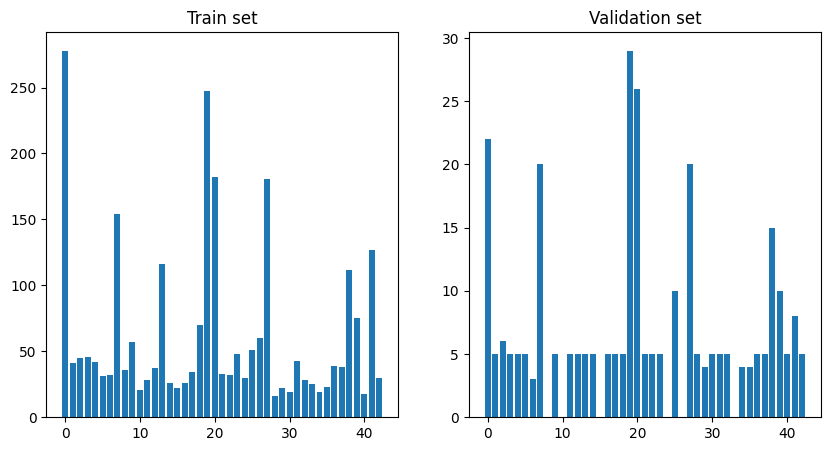

In [ ]:
###Balancing data
import matplotlib.pyplot as plt

#-Showing distribution of test and validation set
unique_train_class, counts_train_class = np.unique(train_dset.labels, return_counts=True)
unique_val_class, counts_val_class = np.unique(val_dset.labels, return_counts=True)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.bar(unique_train_class, counts_train_class)
plt.title('Train set')
plt.subplot(1,2,2)
plt.bar(unique_val_class, counts_val_class)
plt.title('Validation set')
plt.show()

In [ ]:
train_dl = DataLoader(
    train_dset,
    batch_size=cfg_hyp['batch_size'],
    shuffle=True
)

increased_train_dl = DataLoader(
    increased_dataset,
    batch_size=cfg_hyp['batch_size'],
    shuffle=True
)

balanced_train_dl = DataLoader(
    train_dset,
    sampler=train_dset.get_sampler(),
    batch_size=cfg_hyp['batch_size'],
)


val_dl = DataLoader(
    val_dset,
    batch_size=cfg_hyp['batch_size']
)
test_dl = DataLoader(
    test_dset,
    batch_size=cfg_hyp['batch_size']
)


# Utilty function

In [ ]:
# For saving the result
def create_model_directory(model_name, run, resnet=False, hyp_tune=False):
    if resnet:
        base_path = f"./resnet_results_{run}"
    else:
        if hyp_tune:
            base_path = f"./model_results_1/NetWithoutResidualBlock.cnn"
        else:
            base_path = f"./model_results_{run}"
    model_path = os.path.join(base_path, model_name)
    os.makedirs(model_path, exist_ok=True)
    return model_path

In [ ]:
# For counting the parameters of the network
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
# Different way to compute the accurancy of the model
def ncorrect(scores, y):
    y_hat = torch.argmax(scores, -1)
    return (y_hat == y).sum()

def accuracy(scores, y):
    correct = ncorrect(scores, y)
    return correct.true_divide(y.shape[0])

## Training loop

For the training loop we take into account as addictional parameters:
- `scheduler_check`: True if we want to perform the leraning scheduler ReduceLROnPlateau
- `WANDB`: True if we want to log to [Weights and Biases](https://wandb.ai/site)

Instead the `stopping_patience` and the `stopping_value` refers to the EarlyStopping (we stop the training after 10 epochs without improvment or if the validation loss reach the value of 0.7). We also decided to store the results in `model_path`.

In [ ]:
import torch.optim as optim
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, model_name, model_path, stopping_patience = 10, stopping_value = 0.6, scheduler_check=False, WANDB=False):

    model.to(device)
    best_val_acc = 0.0
    if scheduler_check:
      scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.6, patience=2, min_lr = 1e-5)

    if device == 'cuda':
      torch.cuda.empty_cache()

    num_params = count_parameters(model)

    run_stats = {
        "model_name": model_name,
        "num_parameters": num_params,
        "epochs": []
    }

    # Simple storage of train stats
    train_losses = []
    train_accs = []

    val_losses = []
    val_accs = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        start_time = time.time()

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.shape[0]
            train_total += inputs.shape[0]
            train_correct += ncorrect(outputs, labels).item()

            # Storing actual values of train loss and accuracy
            train_losses.append(train_loss/train_total)
            train_accs.append(train_correct/train_total)

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total

        # Validation
        val_loss, val_acc, val_tracks = evaluate_model(model, val_loader, criterion, device)

        val_losses += val_tracks[0]
        val_accs += val_tracks[1]

        if scheduler_check:
          scheduler.step(val_loss)
          last_lr = scheduler.get_last_lr()
        else:
          last_lr = cfg_hyp['lr']

        epoch_time = time.time() - start_time

        epoch_stats = {
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "epoch_time": epoch_time
        }

        run_stats["epochs"].append(epoch_stats)

        if WANDB:
          wandb.log(epoch_stats)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
              f"Time: {epoch_time:.2f}s, "
              f"Last learning rate: {last_lr}")

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            early_stopping_counter = 0
            torch.save(model.state_dict(), os.path.join(model_path, f"{model_name}_best.pth"))
            if WANDB:
              wandb.save(f"{model_name}_best.pth")

        else:
          early_stopping_counter += 1
          print(f"EarlyStoppingCounter: {early_stopping_counter} out of {stopping_patience}")

        if early_stopping_counter >= stopping_patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        if val_acc > stopping_value:
            print(f"Stopping value reached at epoch {epoch+1}")
            break
    
    with open(os.path.join(model_path, f"{model_name}_run_stats.json"), "w") as f:
        json.dump(run_stats, f, indent=2)

    return best_val_acc, (train_losses, train_accs, val_losses, val_accs)

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    # Storing val stats for a single epoch
    val_losses_per_epoch = []
    val_accs_per_epoch = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.shape[0]
            total += inputs.shape[0]
            correct += ncorrect(outputs, labels).item()

            # Storing actual values of train loss and accuracy
            val_losses_per_epoch.append(total_loss/total)
            val_accs_per_epoch.append(correct/total)

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy, (val_losses_per_epoch, val_accs_per_epoch)

def train_and_evaluate(model_class, name, train_loader, val_loader, test_loader, num_classes, model_path, num_epochs=50, lr=0.001, wd=1e-5, device='cuda', stopping_patience = 10, stopping_value = 0.6, scheduler_check=False, resnet=False, fine_tuning=False, WANDB=False):

    if resnet:
      if fine_tuning:
        model = model_class(num_classes=num_classes, weights=ResNet18_Weights.IMAGENET1K_V1)
        model.load_state_dict(torch.load(os.path.join(f"resnet_results_0/{name}", f"{name}_best.pth")))
        pushed_net = model.to(device)
        ## Unfreeze all base model layer
        for layer in [pushed_net.base_model.conv1, pushed_net.base_model.bn1, pushed_net.base_model.layer1, pushed_net.base_model.layer2, pushed_net.base_model.layer3, pushed_net.base_model.layer4]:
            pushed_net.set_requires_grad(layer, train=True)
        # Updating model_name with ft (Fine Tuning)
        name = f'{name}_ft' 
      else:
        pushed_net = model_class(num_classes=num_classes, weights=ResNet18_Weights.IMAGENET1K_V1).to(device)

        ## Freeze base model layer (not fc)
        for layer in [pushed_net.base_model.conv1, pushed_net.base_model.bn1, pushed_net.base_model.layer1, pushed_net.base_model.layer2, pushed_net.base_model.layer3, pushed_net.base_model.layer4]:
            pushed_net.set_requires_grad(layer, train=False)
    else:
      pushed_net = model_class(num_classes=num_classes).to(device)
       
    
    if WANDB:
      wandb.init(project="grocery-store-classification", name=name)
      wandb.watch(pushed_net)

    criterion = F.cross_entropy
    optimizer = optim.AdamW(pushed_net.parameters(), lr=lr, weight_decay=wd)

    best_val_acc, tracks = train_model(pushed_net, train_loader, val_loader, criterion, optimizer, num_epochs, device, name, model_path, stopping_patience, stopping_value, scheduler_check, WANDB)

    # Load the best model for final evaluation
    pushed_net.load_state_dict(torch.load(os.path.join(model_path, f"{name}_best.pth")))
    test_loss, test_acc, test_tracks = evaluate_model(pushed_net, test_loader, criterion, device)

    print(f"Final results for {name}:")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    if WANDB:
      wandb.log({
          "best_val_acc": best_val_acc,
          "test_acc": test_acc
      })

    json_path = os.path.join(model_path, f"{name}_run_stats.json")
    with open(json_path, "r") as f:
        run_stats = json.load(f)

    run_stats["best_val_acc"] = best_val_acc
    run_stats["test_acc"] = test_acc
    
    with open(json_path, "w") as f:
        json.dump(run_stats, f, indent=2)

    if WANDB:
      wandb.finish()


    return best_val_acc, test_acc, tracks, test_tracks

# Part 1

## Networks

The worklow to create the best network started with the simpler one, adding little by little some improvments. Then, once founce the best network, we proceed with the fine-tuning of the hyperparametrs of the training.


In [ ]:
import torch.nn.functional as F

### MoreFullyConnectedNet

We started with a simple ConvNet with 2 Convolutional Layers, followed by 2 MaxPolling Layers, and with 3 FullyConnected Layers. Since it's very basic structure we didn't expect good performance, expecially in terms of generalization.

Number of parameters: **262315**

In [ ]:
class MoreFullyConnectedNet(nn.Module):
    def __init__(self, num_classes=43):
        super(MoreFullyConnectedNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding='valid')
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding='valid')
        self.pool2 = nn.MaxPool2d(2, 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        #self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128,256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        #out = self.dropout1(out)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        #out = self.dropout2(out)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = self.fc3(x)
        return out

### NetWithoutBatchNorm

From the very basic structure we decided te reduce the number of linear layers, growing the number of convolutional layers (for the moment we avoided the use of BatchNormalization layers and dropout). The goal was to create a network able to recognize more features.

Number of parameters: **1573035**

In [ ]:
class NetWithoutBatchNorm(nn.Module):
    def __init__(self, num_classes=43):
        super(NetWithoutBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding='valid')
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding='valid')
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = self.avg_pool(x)
        out = x.view(x.size(0), -1)
        out = self.fc(out)
        return out

### NetWithoutResidualBlock

In this network we decided to adding the Batch Normalization layers with the expectation that this network would be more stable during the process of training than the other ones.

Number of parameters: **1574955**


In [ ]:
class NetWithoutResidualBlock(nn.Module):
    def __init__(self, num_classes=43):
        super(NetWithoutResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding='valid')
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding='valid')
        self.pool2 = nn.MaxPool2d(2, 2)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.bn4 = nn.BatchNorm2d(512)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.bn2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.bn3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = self.bn4(x)
        x = self.avg_pool(x)
        out = x.view(x.size(0), -1)
        out = self.fc(out)
        return out

### NetWithoutDroput

In this network we decided to adding residual connections taking into accunt how they are good in terms of stabilty of the training.

Number of parameters: **4920235**



In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class NetWithoutDropout(nn.Module):
    def __init__(self, num_classes=43):
        super(NetWithoutDropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=4, padding='valid')
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = ResidualBlock(64, 64)
        self.layer2 = ResidualBlock(64, 128, stride=2)
        self.layer3 = ResidualBlock(128, 256, stride=2)
        self.layer4 = ResidualBlock(256, 512, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.pool1(out)
        out = self.bn1(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

### GroceryConvNet

Finally, for the last network, we decided to adding the droput layer, knowing its role in the capabilty of the network to generalize and avoid overfitting.

Number of parameters: **4920235**

In [ ]:
class GroceryConvNet(nn.Module):
    def __init__(self, num_classes=43):
        super(GroceryConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=4, padding='valid')
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = ResidualBlock(64, 64)
        self.layer2 = ResidualBlock(64, 128, stride=2)
        self.layer3 = ResidualBlock(128, 256, stride=2)
        self.layer4 = ResidualBlock(256, 512, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout2 = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.pool1(out)
        out = self.bn1(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout2(out)
        out = self.fc(out)
        return out

## Running experiments

We started training the model on the initial train_dataset (without augmentation or balancing). We recall the initial configuration of the hyperparameters here:

```
[cfg_hyp = {
    'lr' : 3e-4,
    'wd' : 3e-5,
    'epochs' : 30,
    'batch_size' : 64,
    'scheduler' : True,
    'device' : device,
    'stopping_patience' : 10,
    'stopping_value' : 0.7
}]
```



In [ ]:
## Initial configurations of all the models
model = [MoreFullyConnectedNet, NetWithoutBatchNorm, NetWithoutResidualBlock, NetWithoutDropout, GroceryConvNet]
models_name = ['NetMoreFullyConnected.cnn', 'NetWithoutBatchNorm.cnn', 'NetWithoutResidualBlock.cnn', 'NetWithoutDropout.cnn', 'GroceryConvNet.cnn']
experiments = zip(model, models_name)

In [ ]:
## Dictionary to store model perfomances
models_tracks = {}
for model_name in models_name:
  models_tracks[model_name] = {}

In [ ]:
### Two runs for all the model
for run in range(1,2):
  for exp in experiments:
    model, model_name = exp
    if 'tracks' not in models_tracks[model_name].keys():
      model_path = create_model_directory(model_name= model_name, run=run)
      best_val_acc, test_acc, tracks, test_tracks = train_and_evaluate(
        model_class = model,
        name = model_name,
        train_loader = train_dl,
        val_loader = val_dl,
        test_loader = test_dl,
        num_classes = n_classes,
        model_path = model_path,
        num_epochs=cfg_hyp['epochs'],
        lr=cfg_hyp['lr'],
        wd=cfg_hyp['wd'],
        device=cfg_hyp['device'],
        stopping_patience = cfg_hyp['stopping_patience'],
        stopping_value = cfg_hyp['stopping_value'],
        scheduler_check=cfg_hyp['scheduler'],
        WANDB=False
      )
      models_tracks[model_name]['model_path'] = model_path
      models_tracks[model_name]['train_tracks'] = tracks
      models_tracks[model_name]['test_tracks'] = test_tracks

Epoch 1/30, Train Loss: 3.5514, Train Acc: 0.0966, Val Loss: 3.4920, Val Acc: 0.0743, Time: 9.87s, Last learning rate: [0.0003]
Epoch 2/30, Train Loss: 3.3829, Train Acc: 0.1182, Val Loss: 3.4046, Val Acc: 0.1385, Time: 9.65s, Last learning rate: [0.0003]
Epoch 3/30, Train Loss: 3.1135, Train Acc: 0.1852, Val Loss: 3.0486, Val Acc: 0.2095, Time: 9.62s, Last learning rate: [0.0003]
Epoch 4/30, Train Loss: 2.8636, Train Acc: 0.2114, Val Loss: 2.9916, Val Acc: 0.2128, Time: 9.64s, Last learning rate: [0.0003]
Epoch 5/30, Train Loss: 2.7522, Train Acc: 0.2470, Val Loss: 2.9655, Val Acc: 0.1892, Time: 9.76s, Last learning rate: [0.0003]
EarlyStoppingCounter: 1 out of 10
Epoch 6/30, Train Loss: 2.6919, Train Acc: 0.2443, Val Loss: 2.9012, Val Acc: 0.2128, Time: 9.66s, Last learning rate: [0.0003]
EarlyStoppingCounter: 2 out of 10
Epoch 7/30, Train Loss: 2.6245, Train Acc: 0.2424, Val Loss: 2.9584, Val Acc: 0.2128, Time: 9.67s, Last learning rate: [0.0003]
EarlyStoppingCounter: 3 out of 10
Ep

In [ ]:
# Write new models performances in .pickle
for model_name in models_name:
  if 'model_path' in models_tracks[model_name].keys():
    pickle_path = os.path.join(models_tracks[model_name]['model_path'], f"{model_name}_tracks.pickle")
    with open(pickle_path, "wb") as handle:
        pickle.dump(models_tracks[model_name], handle, protocol=pickle.HIGHEST_PROTOCOL)

## Results


We summarize here the results for each netwok in terms of the best validation accuracy reached:

- MoreFullyConnectedNet: **0.3041**
- NetWithoutBatchNorm: **0.4662**
- NetWithoutResidualBlocks: **0.6351**
- NetWithoutDropout: **0.5574**
- GroceryConvNet: **0.5980**

From these results we can see how important is the adding of batch-norm layers and droput, while the adding of residual connections surprisingly not lead to improvment.

## Plots

### Read from pickle files

Execute next cell only if models have already been run, and all models pickle file have been written.

In [ ]:
import pickle

In [ ]:
# Reading models performances saved in .pickle
for model_name in models_name:
  # if 'model_path' in models_tracks[model_name].keys():
  pickle_path = os.path.join(f'model_results_1/{model_name}/', f"{model_name}_tracks.pickle")
  with open(pickle_path, 'rb') as handle:
    models_tracks[model_name] = pickle.load(handle)

### Plot performances

In [ ]:
from matplotlib.patches import Patch
# Create legend in fig rather than an axis
def add_fig_legend(fig, n_groups, group_labels, loc='lower center', ncol=4):
    # Get colours for current style
    colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
    # Set up handles (the bits that are drawn in the legend)
    handles = []
    for group_idx in range(n_groups):
        # Create a simple patch that is the correct colour
        colour = colours[group_idx]
        handles.append(Patch(edgecolor=colour, facecolor=colour, fill=True))
    # Acutally create our figure legend, using the handles and labels
    fig.legend(handles=handles, labels=group_labels, loc=loc, ncol=ncol)

Feedbacks


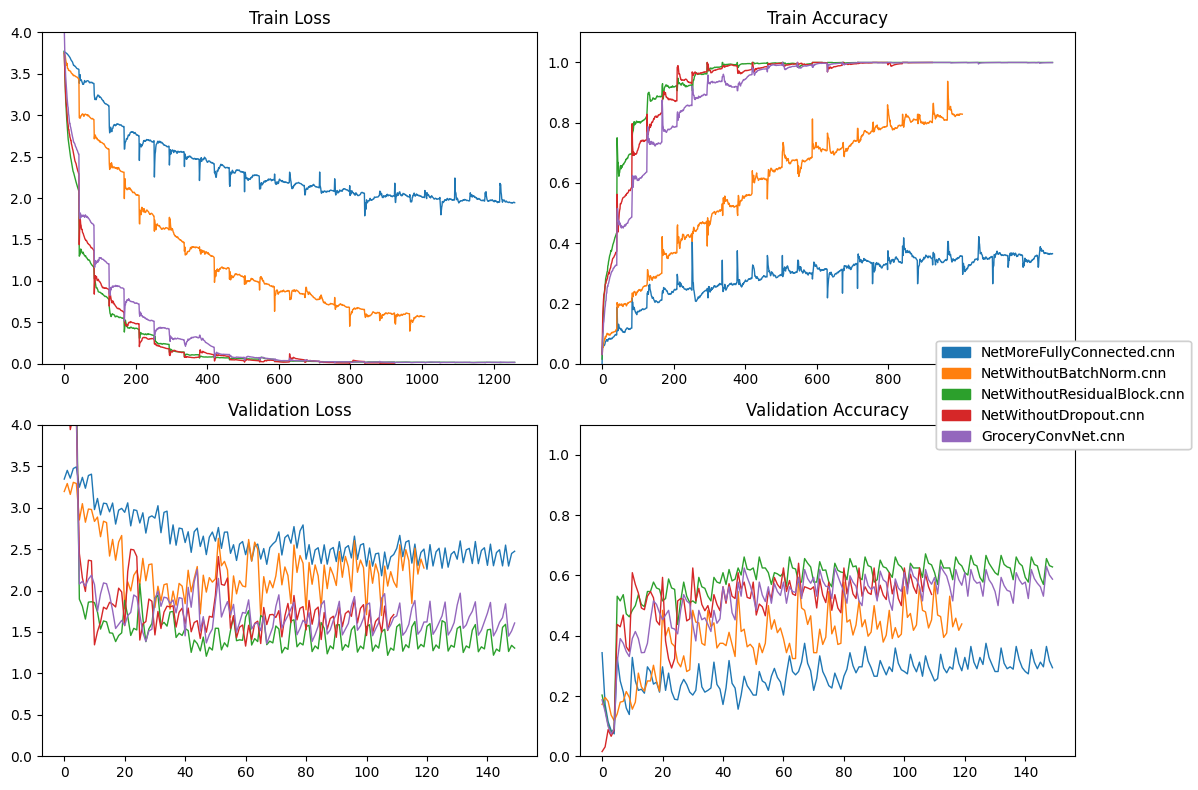

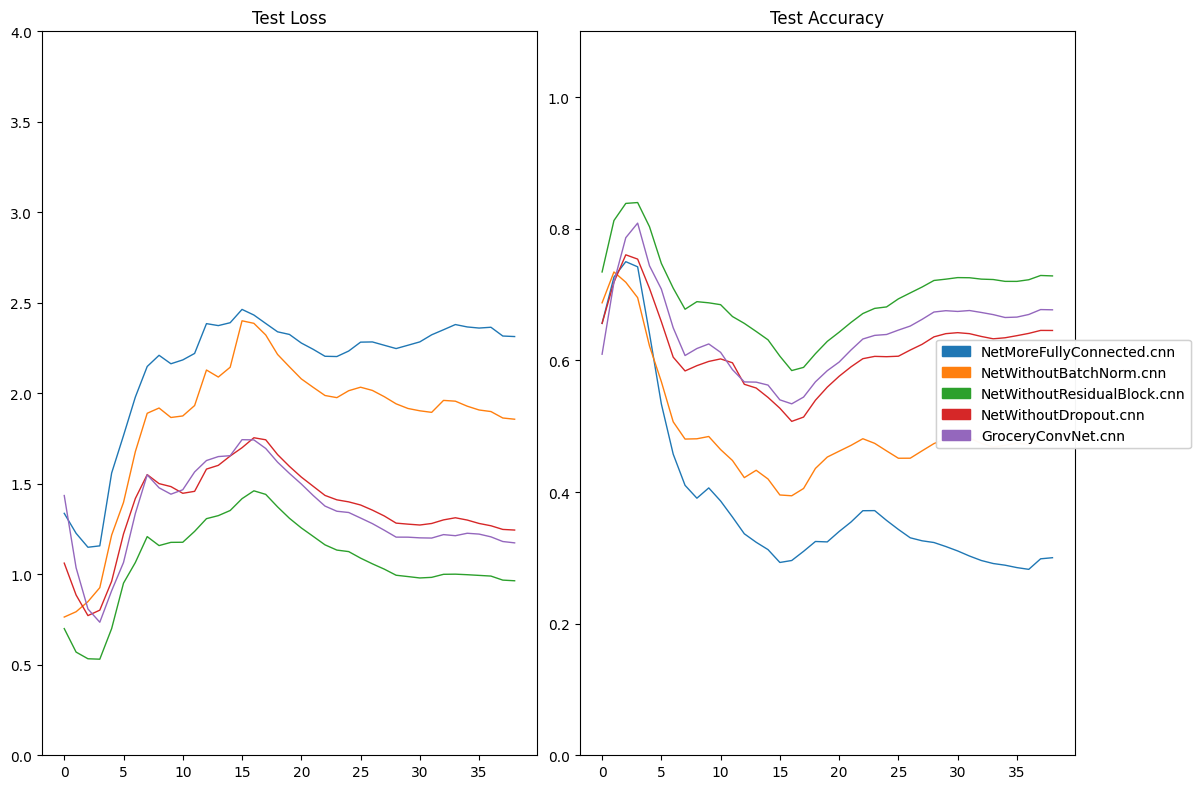

In [ ]:
labels = ['Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy', 'Test Loss', 'Test Accuracy']

print(f'Feedbacks')

# prop_cycle = plt.rcParams['axes.prop_cycle']
# colors = prop_cycle.by_key()['color']

# Legend to right with four axes
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    for model_name in models_name:
        if 'train_tracks' in models_tracks[model_name].keys():
            plt.plot(range(len(models_tracks[model_name]['train_tracks'][i])), models_tracks[model_name]['train_tracks'][i], linewidth=1, label=model_name)
    # plt.yscale('log')
    if i%2==1:
        # plt.ylim(0, max(models_tracks[model_name]['train_tracks'][i]) + 0.1)
        plt.ylim(0, 1.1)
    else:
        plt.ylim(0, 4)
    plt.title(labels[i])
    # Add the figure on the right of the plot this time
    add_fig_legend(fig, len(models_name), models_name, loc='center right', ncol=1)
    fig.patch.set_facecolor('white')
    plt.tight_layout()

    # Remove space from the right handside to make space for the legend
    plt.subplots_adjust(right=0.9)

plt.show()

# Legend to right with four axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
for i in range(4, 6):
    plt.subplot(1, 2, i-3)
    for model_name in models_name:
        if 'test_tracks' in models_tracks[model_name].keys():
            plt.plot(range(len(models_tracks[model_name]['test_tracks'][i-4])), models_tracks[model_name]['test_tracks'][i-4], linewidth=1, label=model_name)

    # plt.yscale('log')
    if i%2==1:
        # plt.ylim(0, max(models_tracks[model_name]['test_tracks'][i-4]) + 0.1)
        plt.ylim(0, 1.1)
    else:
        plt.ylim(0, 4)
    plt.title(labels[i])
    # Add the figure on the right of the plot this time
    add_fig_legend(fig, len(models_name), models_name, loc='center right', ncol=1)
    fig.patch.set_facecolor('white')
    plt.tight_layout()

    # Remove space from the right handside to make space for the legend
    plt.subplots_adjust(right=0.9)
plt.show()

## Tuning hyperparameters for best model

We fine-tuning the hyperparameters for the best model found before (NetWithoutResidualBlocks).
`parameters_runs` is a dictionary prepared in order to specify parameters needed for each run.

In [ ]:
parameters_run = {
    'labels_runs' : ['std + scheduler', 'lower batch size', 'increased dataset', 'balanced dataset', 'std + const_lr'],
    'masked_train_dl': ['train_dl', 'train_dl', 'increased_train_dl', 'balanced_train_dl', 'train_dl'],
    'masked_batch_size': [64, 32, 64, 64, 64],
    'masked_scheduler': [True, True, True, True, False]
}

For each run all parameters modified in the precedent dictionary are passed to the train function through the use of variables used as masks.

In [ ]:
for run in range(len(parameters_run['labels_runs'])):
  # run con cfg['batch_size'] = 32 # 2 run
  # run con cfg['batch_size'] = 64 # 1 run, or otherwise
  # run con cfg['batch_size'] = 128 # not used because of memory problem
  masked_batch_size = parameters_run['masked_batch_size'][run]

  # run con train_dl # 1 run, or otherwise
  # run con increased_train_dl, # 3 run
  # run con balanced_train_dl # 4 run
  if parameters_run['masked_train_dl'] == 'train_dl':
    masked_train_dl = DataLoader(
      train_dset,
      batch_size=masked_batch_size,
      shuffle=True
    )
  elif parameters_run['masked_train_dl'] == 'increased_train_dl':
    masked_train_dl = DataLoader(
      increased_dataset,
      batch_size=masked_batch_size,
      shuffle=True
    )
  else:
    masked_train_dl = DataLoader(
      train_dset,
      sampler=train_dset.get_sampler(),
      batch_size=masked_batch_size,
    )

  val_dl = DataLoader(
      val_dset,
      batch_size=masked_batch_size
  )
  test_dl = DataLoader(
      test_dset,
      batch_size=masked_batch_size
  )


  # run con scheduler ReduceLROnPlateau # 1 run, or otherwise
  # run con scheduler constant # only for 5 run
  masked_scheduler = parameters_run['masked_scheduler'][run]
  if masked_scheduler == False:
    cfg_hyp['lr'] = 3e-5
  else:
    cfg_hyp['lr'] = 3e-4

  model, model_name = NetWithoutResidualBlock, f'hyptune_NetWithoutResidualBlock.cnn_{parameters_run["labels_runs"][run]}'
  if model_name not in models_tracks.keys():
    models_tracks[model_name] = {}

  if 'train_tracks' not in models_tracks[model_name].keys():
    model_path = create_model_directory(model_name= model_name, run=run, hyp_tune=True)
    best_val_acc, test_acc, tracks, test_tracks = train_and_evaluate(
      model_class = model,
      name = model_name,
      train_loader = masked_train_dl,
      val_loader = val_dl,
      test_loader = test_dl,
      num_classes = n_classes,
      model_path = model_path,
      num_epochs=cfg_hyp['epochs'],
      lr=cfg_hyp['lr'],
      wd=cfg_hyp['wd'],
      device=cfg_hyp['device'],
      stopping_patience = cfg_hyp['stopping_patience'],
      stopping_value = cfg_hyp['stopping_value'],
      scheduler_check=masked_scheduler,
      WANDB=False
    )
    models_tracks[model_name]['model_path'] = model_path
    models_tracks[model_name]['train_tracks'] = tracks
    models_tracks[model_name]['test_tracks'] = test_tracks


Epoch 1/30, Train Loss: 2.9492, Train Acc: 0.2667, Val Loss: 3.6761, Val Acc: 0.0203, Time: 10.44s, Last learning rate: 3e-05
Epoch 2/30, Train Loss: 2.2207, Train Acc: 0.5182, Val Loss: 2.8408, Val Acc: 0.1993, Time: 10.19s, Last learning rate: 3e-05
Epoch 3/30, Train Loss: 1.8791, Train Acc: 0.6265, Val Loss: 2.6411, Val Acc: 0.2466, Time: 10.21s, Last learning rate: 3e-05
Epoch 4/30, Train Loss: 1.6595, Train Acc: 0.6860, Val Loss: 2.5039, Val Acc: 0.2365, Time: 10.19s, Last learning rate: 3e-05
EarlyStoppingCounter: 1 out of 10
Epoch 5/30, Train Loss: 1.4705, Train Acc: 0.7322, Val Loss: 2.4048, Val Acc: 0.2736, Time: 10.13s, Last learning rate: 3e-05
Epoch 6/30, Train Loss: 1.3187, Train Acc: 0.7754, Val Loss: 2.3182, Val Acc: 0.3074, Time: 10.08s, Last learning rate: 3e-05
Epoch 7/30, Train Loss: 1.1650, Train Acc: 0.8235, Val Loss: 2.2914, Val Acc: 0.3209, Time: 10.25s, Last learning rate: 3e-05
Epoch 8/30, Train Loss: 1.0807, Train Acc: 0.8254, Val Loss: 2.1695, Val Acc: 0.3750

## Results of the fine-tuning of the hyperparameters

We summarize here the results of the fine tuning in terms of best validation accuracy reached:
- Using balanced dataset: **0.601**
- Using data augmenatation: **0.625**
- Using lower batch size: **0.625**
- Using a costant learning rate on the standard training set: **0.527**
- Using a leraning rate scheduler on the standard training set: **0.601**

We can see how a good preprocessing of the dataset and an approprietly learning rate scheduer improve the perfomance.

In [ ]:
# Write new models performances in .pickle
for model_name in parameters_run['labels_runs']:
  if 'model_path' in models_tracks[f'hyptune_NetWithoutResidualBlock.cnn_{model_name}'].keys():
    pickle_path = os.path.join(models_tracks[f'hyptune_NetWithoutResidualBlock.cnn_{model_name}']['model_path'], f"{model_name}_tracks.pickle")
    with open(pickle_path, "wb") as handle:
        pickle.dump(models_tracks[f'hyptune_NetWithoutResidualBlock.cnn_{model_name}'], handle, protocol=pickle.HIGHEST_PROTOCOL)

## Plot of Best Model performances for each run

In [ ]:
# Reading models performances saved in .pickle
for model_name in parameters_run['labels_runs']:
  pickle_path = os.path.join(models_tracks[f'hyptune_NetWithoutResidualBlock.cnn_{model_name}']['model_path'], f"{model_name}_tracks.pickle")
  with open(pickle_path, 'rb') as handle:
    models_tracks[f'hyptune_NetWithoutResidualBlock.cnn_{model_name}'] = pickle.load(handle)

Feedbacks


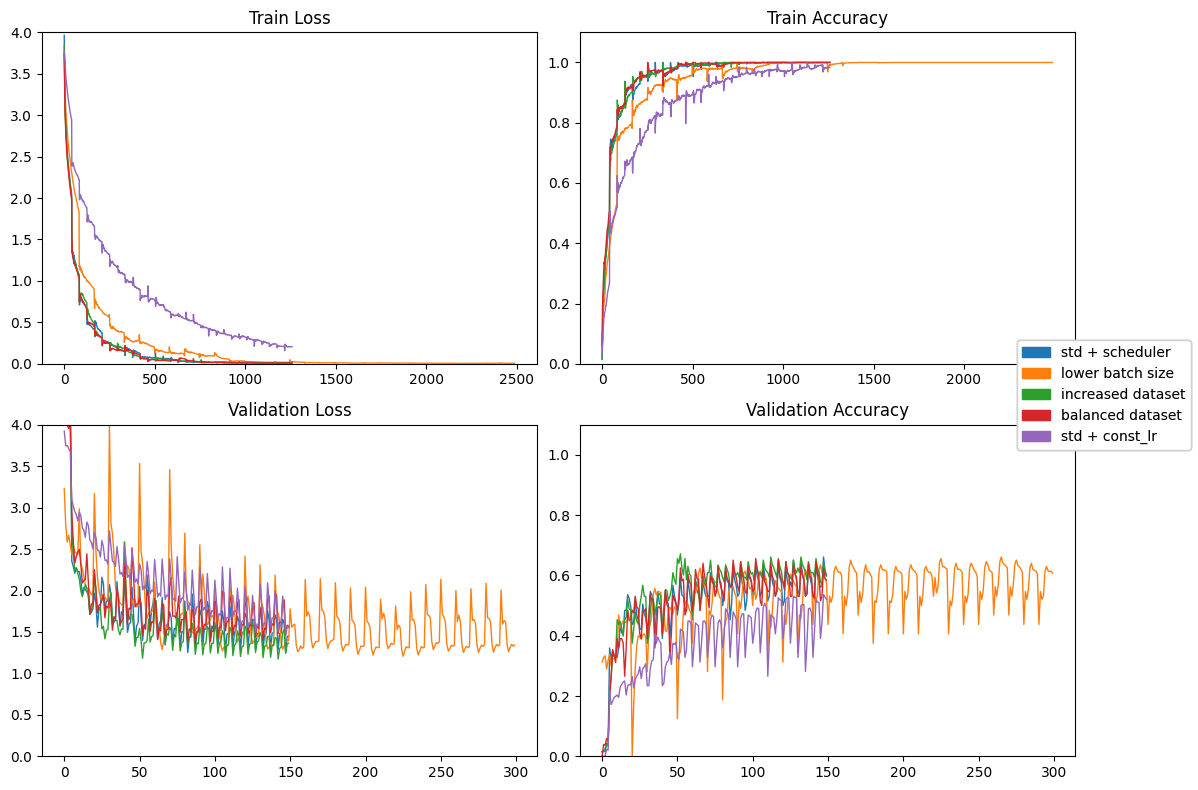

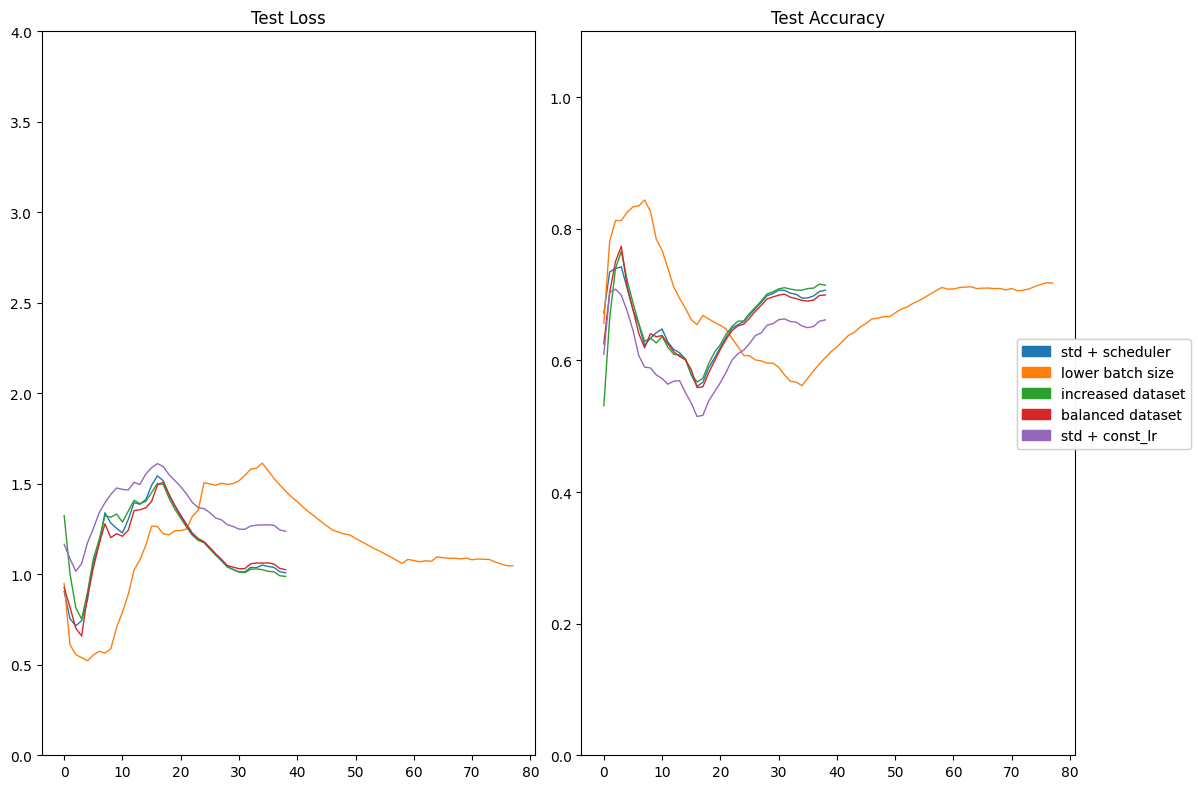

In [ ]:
labels = ['Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy', 'Test Loss', 'Test Accuracy']

print(f'Feedbacks')

# Legend to right with four axes
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    for model_name in parameters_run['labels_runs']:
        if 'train_tracks' in models_tracks[f'hyptune_NetWithoutResidualBlock.cnn_{model_name}'].keys():
            plt.plot(range(len(models_tracks[f'hyptune_NetWithoutResidualBlock.cnn_{model_name}']['train_tracks'][i])), models_tracks[f'hyptune_NetWithoutResidualBlock.cnn_{model_name}']['train_tracks'][i], linewidth=1, label=model_name)
    if i%2==1:
        plt.ylim(0, 1.1)
    else:
        plt.ylim(0, 4)
    plt.title(labels[i])
    # Add the figure on the right of the plot this time
    add_fig_legend(fig, len(parameters_run['labels_runs']), parameters_run['labels_runs'], loc='center right', ncol=1)
    fig.patch.set_facecolor('white')
    plt.tight_layout()

    # Remove space from the right handside to make space for the legend
    plt.subplots_adjust(right=0.9)

plt.show()

# Legend to right with four axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
for i in range(4, 6):
    plt.subplot(1, 2, i-3)
    for model_name in parameters_run['labels_runs']:
        if 'test_tracks' in models_tracks[f'hyptune_NetWithoutResidualBlock.cnn_{model_name}'].keys():
            plt.plot(range(len(models_tracks[f'hyptune_NetWithoutResidualBlock.cnn_{model_name}']['test_tracks'][i-4])), models_tracks[f'hyptune_NetWithoutResidualBlock.cnn_{model_name}']['test_tracks'][i-4], linewidth=1, label=model_name)

    if i%2==1:
        plt.ylim(0, 1.1)
    else:
        plt.ylim(0, 4)
    plt.title(labels[i])
    # Add the figure on the right of the plot this time
    add_fig_legend(fig, len(parameters_run['labels_runs']), parameters_run['labels_runs'], loc='center right', ncol=1)
    fig.patch.set_facecolor('white')
    plt.tight_layout()

    # Remove space from the right handside to make space for the legend
    plt.subplots_adjust(right=0.9)
plt.show()

# Part 2

## Initial set up of hyperparameters

In [ ]:
##Configurations
cfg_data = {
    'std_size' : 224,
    'rand_crop_size' : 150,
    'n_classes' : 43,
}

cfg_hyp = {
    'lr' : 3e-4,
    'wd' : 3e-5,
    'epochs' : 30,
    'batch_size' : 64,
    'scheduler' : True,
    'device' : device,
    'stopping_patience' : 10,
    'stopping_value' : 0.9
}


## Build new datasets with different standard size (224x224)

For the training of the Res-Net we changed the input dimension of the image, so we recalled the DataLoader

In [ ]:
n_classes = cfg_data['n_classes']

tsfms_std = T.Compose([
    T.Resize(size=(cfg_data['std_size'], cfg_data['std_size'])),
    T.ToTensor(),
    # T.Lambda(lambda x: x.flatten()),
])


## DATAAUGMENTATION
class RandomApply(T.RandomApply):
    def __init__(self, transforms, p=0.5):
        super().__init__(transforms, p=p)

def change_background_color(image):
    background = Image.new('RGB', image.size, (random.randint(200, 255), random.randint(200, 255), random.randint(200, 255)))
    return Image.composite(image, background, image.convert('L').point(lambda x: 255 if x > 5 else 0))


tsfms_increasing = T.Compose([
        T.RandomRotation(10),
        T.RandomResizedCrop(32, scale=(0.9, 1.0)),
        T.RandomHorizontalFlip(p=0.3),
        RandomApply([T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)], p=0.7),
        RandomApply([T.GaussianBlur(kernel_size=3)], p=0.2),
        T.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        RandomApply([T.Lambda(change_background_color)], p=0.3),
        T.RandomResizedCrop(size=(cfg_data['rand_crop_size'], cfg_data['rand_crop_size']), scale=(0.8, 1.0)),
        T.ToTensor(),
        T.Resize(size=(cfg_data['std_size'], cfg_data['std_size'])),
        RandomApply([
            T.Lambda(lambda x: x + 0.02 * torch.randn_like(x))
        ], p=0.2),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


train_dset = GroceryStoreDataset(
    split="train",
    transform=tsfms_std,
)
increased_train_dst = GroceryStoreDataset(
    split="train",
    transform=tsfms_increasing,
)

val_dset = GroceryStoreDataset(
    split="val",
    transform=tsfms_std,
)
test_dset = GroceryStoreDataset(
    split="test",
    transform=tsfms_std,
)
increased_dataset = torch.utils.data.ConcatDataset([increased_train_dst,train_dset]) #-> augmented data

print(f'Train dataset size: {len(train_dset)}')
print(f'Increased train dataset size: {len(increased_dataset)}')
print(f'Validation dataset size: {len(val_dset)}')
print(f'Test dataset size: {len(test_dset)}')

Train dataset size: 2640
Increased train dataset size: 5280
Validation dataset size: 296
Test dataset size: 2485


In [ ]:
train_dl = DataLoader(
    train_dset,
    batch_size=cfg_hyp['batch_size'],
    shuffle=True
)

increased_train_dl = DataLoader(
    increased_dataset,
    batch_size=cfg_hyp['batch_size'],
    shuffle=True
)

balanced_train_dl = DataLoader(
    train_dset,
    sampler=train_dset.get_sampler(),
    batch_size=cfg_hyp['batch_size'],
)


val_dl = DataLoader(
    val_dset,
    batch_size=cfg_hyp['batch_size']
)
test_dl = DataLoader(
    test_dset,
    batch_size=cfg_hyp['batch_size']
)


## ResNet18 Model

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

In [ ]:
class Resnet18(torch.nn.Module):
    def __init__(self, num_classes, weights):
        super().__init__()
        self.base_model = resnet18(weights=weights)
        self.base_model.fc = torch.nn.Linear(self.base_model.fc.in_features, n_classes)
    
    def set_requires_grad(self, layer, train):
        for p in layer.parameters():
            p.requires_grad = train
    
    def forward(self, x):
        x = self.base_model(x)
        return x


## Tune hyperparameters (Freeze base model phase)

In [ ]:
parameters_run = {
    'labels_runs' : ['std + scheduler'],
    'masked_train_dl': ['train_dl'],
    'masked_batch_size': [64],
    'masked_scheduler': [True]
}

For each run all parameters modified in the precedent dictionary are passed to the train function through the use of variables used as masks. 

In [ ]:
models_tracks = {}
model_name = 'ResNet18'
for name in parameters_run['labels_runs']:
  models_tracks[f'{model_name}_{name}'] = {}

In [ ]:
for run in range(len(parameters_run['labels_runs'])):
  masked_batch_size = parameters_run['masked_batch_size'][run]

  if parameters_run['masked_train_dl'] == 'train_dl':
    masked_train_dl = DataLoader(
      train_dset,
      batch_size=masked_batch_size,
      shuffle=True
    )
  elif parameters_run['masked_train_dl'] == 'increased_train_dl':
    masked_train_dl = DataLoader(
      increased_dataset,
      batch_size=masked_batch_size,
      shuffle=True
    )
  else:
    masked_train_dl = DataLoader(
      train_dset,
      sampler=train_dset.get_sampler(),
      batch_size=masked_batch_size,
    )
  
  val_dl = DataLoader(
      val_dset,
      batch_size=masked_batch_size
  )
  test_dl = DataLoader(
      test_dset,
      batch_size=masked_batch_size
  )

  masked_scheduler = parameters_run['masked_scheduler'][run]
  if masked_scheduler == False:
    cfg_hyp['lr'] = 3e-5
  else:
    cfg_hyp['lr'] = 3e-4
  
  model, model_name = Resnet18, f'ResNet18_{parameters_run["labels_runs"][run]}'
  if model_name not in models_tracks.keys():
    models_tracks[model_name] = {}
  
  if 'train_tracks' not in models_tracks[model_name].keys():
    model_path = create_model_directory(model_name= model_name, run=run, resnet=True, hyp_tune=True)
    best_val_acc, test_acc, tracks, test_tracks = train_and_evaluate(
      model_class = model,
      name = model_name,
      train_loader = masked_train_dl,
      val_loader = val_dl,
      test_loader = test_dl,
      num_classes = n_classes,
      model_path = model_path,
      num_epochs=cfg_hyp['epochs'],
      lr=cfg_hyp['lr'],
      wd=cfg_hyp['wd'],
      device=cfg_hyp['device'],
      stopping_patience = cfg_hyp['stopping_patience'],
      stopping_value = cfg_hyp['stopping_value'],
      scheduler_check=masked_scheduler,
      resnet=True,
      fine_tuning=False,
      WANDB=False
    )
    models_tracks[model_name]['model_path'] = model_path
    models_tracks[model_name]['train_tracks'] = tracks
    models_tracks[model_name]['test_tracks'] = test_tracks


Epoch 1/30, Train Loss: 3.4793, Train Acc: 0.1470, Val Loss: 3.3925, Val Acc: 0.1115, Time: 10.51s, Last learning rate: [0.0003]
Epoch 2/30, Train Loss: 2.7310, Train Acc: 0.4788, Val Loss: 2.8624, Val Acc: 0.2601, Time: 10.13s, Last learning rate: [0.0003]
Epoch 3/30, Train Loss: 2.1871, Train Acc: 0.6716, Val Loss: 2.5243, Val Acc: 0.3885, Time: 10.12s, Last learning rate: [0.0003]
Epoch 4/30, Train Loss: 1.7524, Train Acc: 0.7689, Val Loss: 2.2428, Val Acc: 0.4696, Time: 10.22s, Last learning rate: [0.0003]
Epoch 5/30, Train Loss: 1.4662, Train Acc: 0.8223, Val Loss: 2.0083, Val Acc: 0.5507, Time: 10.23s, Last learning rate: [0.0003]
Epoch 6/30, Train Loss: 1.2493, Train Acc: 0.8625, Val Loss: 1.8879, Val Acc: 0.5338, Time: 10.22s, Last learning rate: [0.0003]
EarlyStoppingCounter: 1 out of 10
Epoch 7/30, Train Loss: 1.0426, Train Acc: 0.8962, Val Loss: 1.7797, Val Acc: 0.5709, Time: 10.56s, Last learning rate: [0.0003]
Epoch 8/30, Train Loss: 0.9307, Train Acc: 0.8936, Val Loss: 1.

In [ ]:
# Write new models performances in .pickle
for model_name in parameters_run['labels_runs']:
  if 'model_path' in models_tracks[f'ResNet18_{model_name}'].keys():
    pickle_path = os.path.join(models_tracks[f'ResNet18_{model_name}']['model_path'], f"{model_name}_tracks.pickle")
    with open(pickle_path, "wb") as handle:
        pickle.dump(models_tracks[f'ResNet18_{model_name}'], handle, protocol=pickle.HIGHEST_PROTOCOL)

## Results with the frezee model

Only with the fine-tuning of the hyperparamters we reached the results of **0.746** as accuracy of the validation set.

## Plots

In [ ]:
# Reading models performances saved in .pickle
for model_name in parameters_run['labels_runs']:
  pickle_path = os.path.join(f'resnet_results_0/ResNet18_{model_name}', f"{model_name}_tracks.pickle")
  with open(pickle_path, 'rb') as handle:
    models_tracks[f'ResNet18_{model_name}'] = pickle.load(handle)

Feedbacks


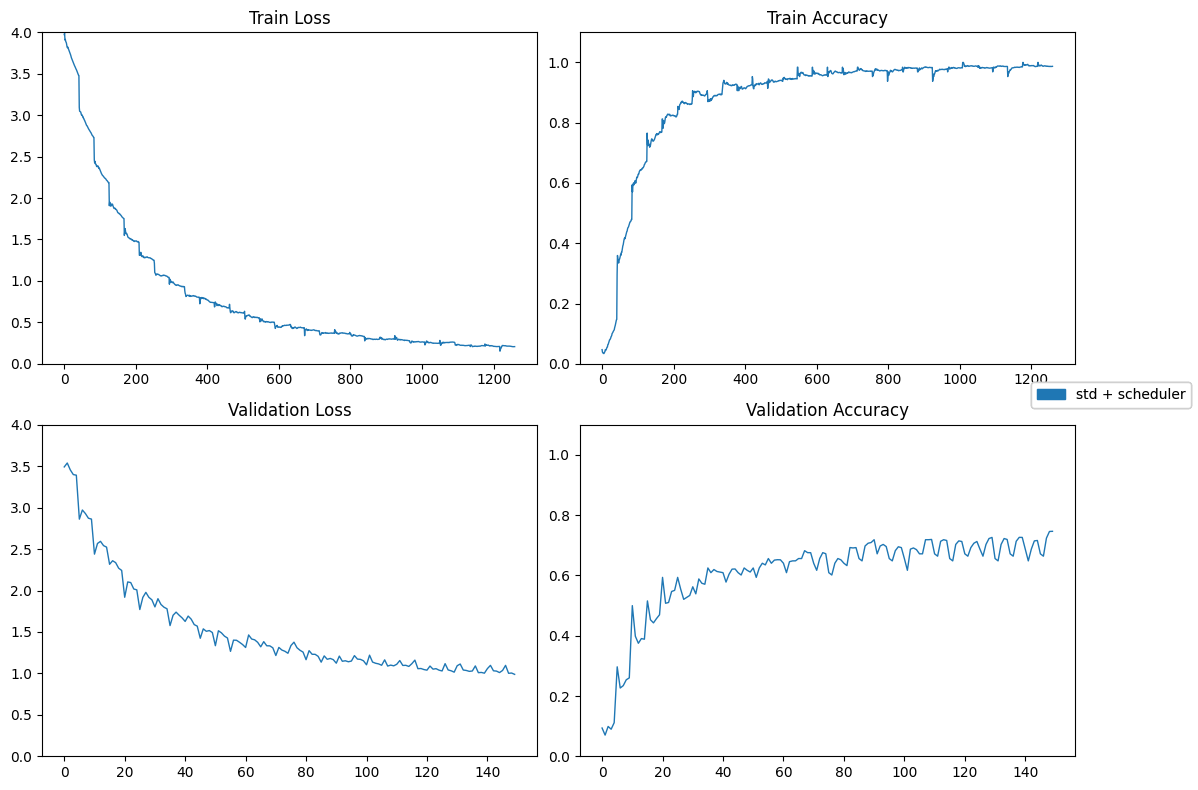

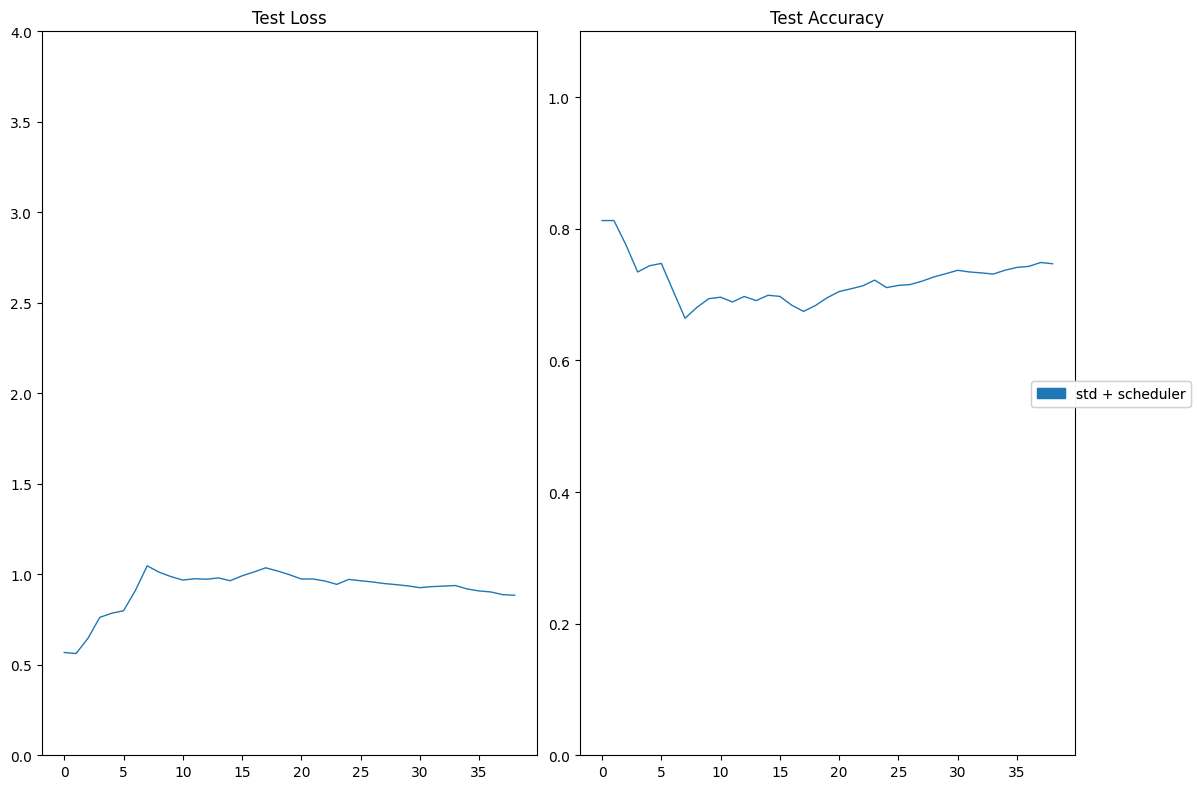

In [ ]:
labels = ['Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy', 'Test Loss', 'Test Accuracy']

print(f'Feedbacks')

# Legend to right with four axes
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    for model_name in parameters_run['labels_runs']:
        if 'train_tracks' in models_tracks[f'ResNet18_{model_name}'].keys():
            plt.plot(range(len(models_tracks[f'ResNet18_{model_name}']['train_tracks'][i])), models_tracks[f'ResNet18_{model_name}']['train_tracks'][i], linewidth=1, label=model_name)
    if i%2==1:
        plt.ylim(0, 1.1)
    else:
        plt.ylim(0, 4)
    plt.title(labels[i])
    # Add the figure on the right of the plot this time
    add_fig_legend(fig, len(parameters_run['labels_runs']), parameters_run['labels_runs'], loc='center right', ncol=1)
    fig.patch.set_facecolor('white')
    plt.tight_layout()

    # Remove space from the right handside to make space for the legend
    plt.subplots_adjust(right=0.9)

plt.show()

# Legend to right with four axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
for i in range(4, 6):
    plt.subplot(1, 2, i-3)
    for model_name in parameters_run['labels_runs']:
        if 'test_tracks' in models_tracks[f'ResNet18_{model_name}'].keys():
            plt.plot(range(len(models_tracks[f'ResNet18_{model_name}']['test_tracks'][i-4])), models_tracks[f'ResNet18_{model_name}']['test_tracks'][i-4], linewidth=1, label=model_name)

    if i%2==1:
        plt.ylim(0, 1.1)
    else:
        plt.ylim(0, 4)
    plt.title(labels[i])
    # Add the figure on the right of the plot this time
    add_fig_legend(fig, len(parameters_run['labels_runs']), parameters_run['labels_runs'], loc='center right', ncol=1)
    fig.patch.set_facecolor('white')
    plt.tight_layout()

    # Remove space from the right handside to make space for the legend
    plt.subplots_adjust(right=0.9)
plt.show()

## Fine tune hyperparameters (Unfreeze layers)

In [ ]:
parameters_run = {
    'labels_runs' : ['std + scheduler'],
    'masked_train_dl': ['train_dl'],
    'masked_batch_size': [64],
    'masked_scheduler': [True]
}

In [ ]:
for run in range(len(parameters_run['labels_runs'])):
  masked_batch_size = parameters_run['masked_batch_size'][run]

  if parameters_run['masked_train_dl'] == 'train_dl':
    masked_train_dl = DataLoader(
      train_dset,
      batch_size=masked_batch_size,
      shuffle=True
    )
  elif parameters_run['masked_train_dl'] == 'increased_train_dl':
    masked_train_dl = DataLoader(
      increased_dataset,
      batch_size=masked_batch_size,
      shuffle=True
    )
  else:
    masked_train_dl = DataLoader(
      train_dset,
      sampler=train_dset.get_sampler(),
      batch_size=masked_batch_size,
    )
  
  val_dl = DataLoader(
      val_dset,
      batch_size=masked_batch_size
  )
  test_dl = DataLoader(
      test_dset,
      batch_size=masked_batch_size
  )

  masked_scheduler = parameters_run['masked_scheduler'][run]
  if masked_scheduler == False:
    cfg_hyp['lr'] = 5e-6
  else:
    cfg_hyp['lr'] = 8e-6
  
  model, model_name = Resnet18, f'ResNet18_{parameters_run["labels_runs"][run]}'
  if f'{model_name}_ft' not in models_tracks.keys():
    models_tracks[f'{model_name}_ft'] = {}
  
  if 'train_tracks' not in models_tracks[f'{model_name}_ft'].keys():
    model_path = create_model_directory(model_name= f'{model_name}_ft', run=run, resnet=True, hyp_tune=True)
    best_val_acc, test_acc, tracks, test_tracks = train_and_evaluate(
      model_class = model,
      name = model_name,
      train_loader = masked_train_dl,
      val_loader = val_dl,
      test_loader = test_dl,
      num_classes = n_classes,
      model_path = model_path,
      num_epochs=cfg_hyp['epochs'],
      lr=cfg_hyp['lr'],
      wd=cfg_hyp['wd'],
      device=cfg_hyp['device'],
      stopping_patience = cfg_hyp['stopping_patience'],
      stopping_value = cfg_hyp['stopping_value'],
      scheduler_check=masked_scheduler,
      resnet=True,
      fine_tuning=True,
      WANDB=False
    )
    models_tracks[f'{model_name}_ft']['model_path'] = model_path
    models_tracks[f'{model_name}_ft']['train_tracks'] = tracks
    models_tracks[f'{model_name}_ft']['test_tracks'] = test_tracks


Epoch 1/30, Train Loss: 0.1608, Train Acc: 0.9902, Val Loss: 0.8985, Val Acc: 0.7432, Time: 17.33s, Last learning rate: [8e-06]
Epoch 2/30, Train Loss: 0.0977, Train Acc: 0.9962, Val Loss: 0.8230, Val Acc: 0.7703, Time: 17.32s, Last learning rate: [8e-06]
Epoch 3/30, Train Loss: 0.0736, Train Acc: 0.9966, Val Loss: 0.7885, Val Acc: 0.7703, Time: 17.43s, Last learning rate: [8e-06]
EarlyStoppingCounter: 1 out of 10
Epoch 4/30, Train Loss: 0.0610, Train Acc: 0.9973, Val Loss: 0.7562, Val Acc: 0.7703, Time: 17.66s, Last learning rate: [8e-06]
EarlyStoppingCounter: 2 out of 10
Epoch 5/30, Train Loss: 0.0430, Train Acc: 0.9989, Val Loss: 0.7349, Val Acc: 0.7872, Time: 17.84s, Last learning rate: [8e-06]
Epoch 6/30, Train Loss: 0.0342, Train Acc: 0.9992, Val Loss: 0.7009, Val Acc: 0.7939, Time: 17.96s, Last learning rate: [8e-06]
Epoch 7/30, Train Loss: 0.0291, Train Acc: 1.0000, Val Loss: 0.7137, Val Acc: 0.7838, Time: 17.97s, Last learning rate: [8e-06]
EarlyStoppingCounter: 1 out of 10
Ep

## Results with the unfreeze model


With the fine-tuning of the last layers the Res-Net reach the value of **0.831** of the accuracy on the validation set